Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4509 - loss: 1.0650 - val_accuracy: 0.4286 - val_loss: 1.0638
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4733 - loss: 1.0496 - val_accuracy: 0.4333 - val_loss: 1.0625
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4549 - loss: 1.0377 - val_accuracy: 0.4286 - val_loss: 1.0663
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5085 - loss: 1.0131 - val_accuracy: 0.4333 - val_loss: 1.0575
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5166 - loss: 1.0039 - val_accuracy: 0.4810 - val_loss: 1.0462
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5100 - loss: 1.0033 - val_accuracy: 0.4667 - val_loss: 1.0482
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5399 - loss: 0.9893 - val_accuracy: 0.4857 - val_loss: 1.0485
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5563 - loss: 0.9614 - val_accuracy: 0.4524 - v

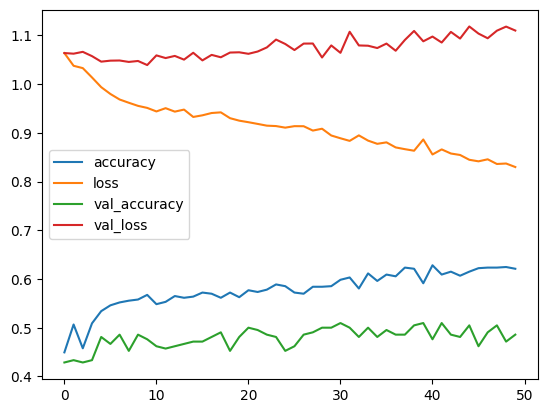

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

matchData = pd.read_csv("PremierLeagueMatches_updated.csv").dropna(subset=["Result"]).drop(columns=["Date", "*Additional Stats", "Attendance"])

# Select features and target and train the model
X = matchData.drop(columns=["homeScore","homeXG","awayScore","awayXG","Result"])
y = matchData["Result"]

# Encode the target feature
resultEncoder = LabelEncoder()
y_encoded = resultEncoder.fit_transform(y)
resultMapping = dict(zip(resultEncoder.classes_, range(len(resultEncoder.classes_))))

# Define qualitative features
qualCols = ["Time", "Home Team", "Away Team", "Referee", "Stadium"]
qualColEncoders = {}

for feature in qualCols:
    newLabelEncoder = LabelEncoder()
    qualColEncoders[feature] = newLabelEncoder
    X[feature] = newLabelEncoder.fit_transform(X[feature])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define neural network
model = keras.Sequential([
    keras.layers.Input(shape = (X_train_scaled.shape[1],)),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(216, activation="relu"),
    keras.layers.Dense(len(resultMapping), activation="softmax")
])

# Huber Loss
huberLoss = tf.keras.losses.Huber(delta=1.0)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test))

modelLosses = pd.DataFrame(model.history.history)
modelLosses.plot()

# Evaluaing the model
predictions = model.predict(X_test_scaled)
predictions_class_labels = np.argmax(predictions, axis=1)
print(f"Accuracy: {accuracy_score(y_test, predictions_class_labels)}")


In [ ]:
# Creating an interactive widget

import ipywidgets as widgets
import warnings
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")

matchday = widgets.BoundedIntText(value=1, min=1, max=38, description="Enter the matchday: ")
# date = widgets.(description="Select the date: ")
time = widgets.Dropdown(options=matchData["Time"].unique().tolist(), description="Select the kickoff time: ")
homeTeam = widgets.Dropdown(options=matchData["Home Team"].unique().tolist(), description="Select the home team: ")
awayTeam = widgets.Dropdown(options=matchData["Away Team"].unique().tolist(), description="Select the away team: ")
ref = widgets.Dropdown(options=matchData["Referee"].unique().tolist(), description="Select the referee: ")
stadium = widgets.Dropdown(options=matchData["Stadium"].unique().tolist(), description="Select the stadium: ")
prevHomePoints = widgets.BoundedIntText(value=0, min=0, max=111, description="Enter the number of points the home team had before the match: ")
prevAwayPoints = widgets.BoundedIntText(value=0, min=0, max=111, description="Enter the number of points the away team had before the match: ")

predictButton = widgets.Button(description="Predict winner")

def predict_outcome(b):
    with output:
        clear_output()

        decodedTime = qualColEncoders["Time"].transform([time.value])[0]
        decodedHomeTeam = qualColEncoders["Home Team"].transform([homeTeam.value])[0]
        decodedAwayTeam = qualColEncoders["Away Team"].transform([awayTeam.value])[0]
        decodedReferee = qualColEncoders["Referee"].transform([ref.value])[0]
        decodedStadium = qualColEncoders["Stadium"].transform([stadium.value])[0]

        input = np.array([matchday.value, decodedTime, decodedHomeTeam, decodedAwayTeam, decodedReferee, decodedStadium, prevHomePoints.value, prevAwayPoints.value])
        input = input.reshape(1,8)
        input = scaler.transform(input)

        predictedProbs = model.predict(input)
        predictedClass = np.argmax(predictedProbs, axis=1)[0]
        originalLabels = list(resultMapping.keys())
        predictedOutcome = originalLabels[predictedClass]

        resultToTeamMapping = {"D": "Draw", "A": awayTeam.value, "H": homeTeam.value}

        print("Result probabilities: ")
        for i, label in enumerate(originalLabels):
            print(f"{resultToTeamMapping[label]}: {predictedProbs[0][i]:.4f}")
        print(f"\nPredicted winner: {resultToTeamMapping[predictedOutcome]}")

predictButton.on_click(predict_outcome)
output = widgets.Output()
display(matchday, time, homeTeam, awayTeam, ref, stadium, prevHomePoints, prevAwayPoints, predictButton, output)

BoundedIntText(value=1, description='Enter the matchday: ', max=38, min=1)

Dropdown(description='Select the kickoff time: ', options=('20:00', '12:30', '15:00', '17:30', '14:00', '16:30…

Dropdown(description='Select the home team: ', options=('Crystal Palace', 'Fulham', 'Tottenham', 'Newcastle Ut…

Dropdown(description='Select the away team: ', options=('Arsenal', 'Liverpool', 'Southampton', "Nott'ham Fores…

Dropdown(description='Select the referee: ', options=('Anthony Taylor', 'Andy Madley', 'Andre Marriner', 'Simo…

Dropdown(description='Select the stadium: ', options=('Selhurst Park', 'Craven Cottage', 'Tottenham Hotspur St…

BoundedIntText(value=0, description='Enter the number of points the home team had before the match: ', max=111…

BoundedIntText(value=0, description='Enter the number of points the away team had before the match: ', max=111…

Button(description='Predict winner', style=ButtonStyle())

Output()